In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *

from scipy import signal as sg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os

# Align IMU, GT Shift

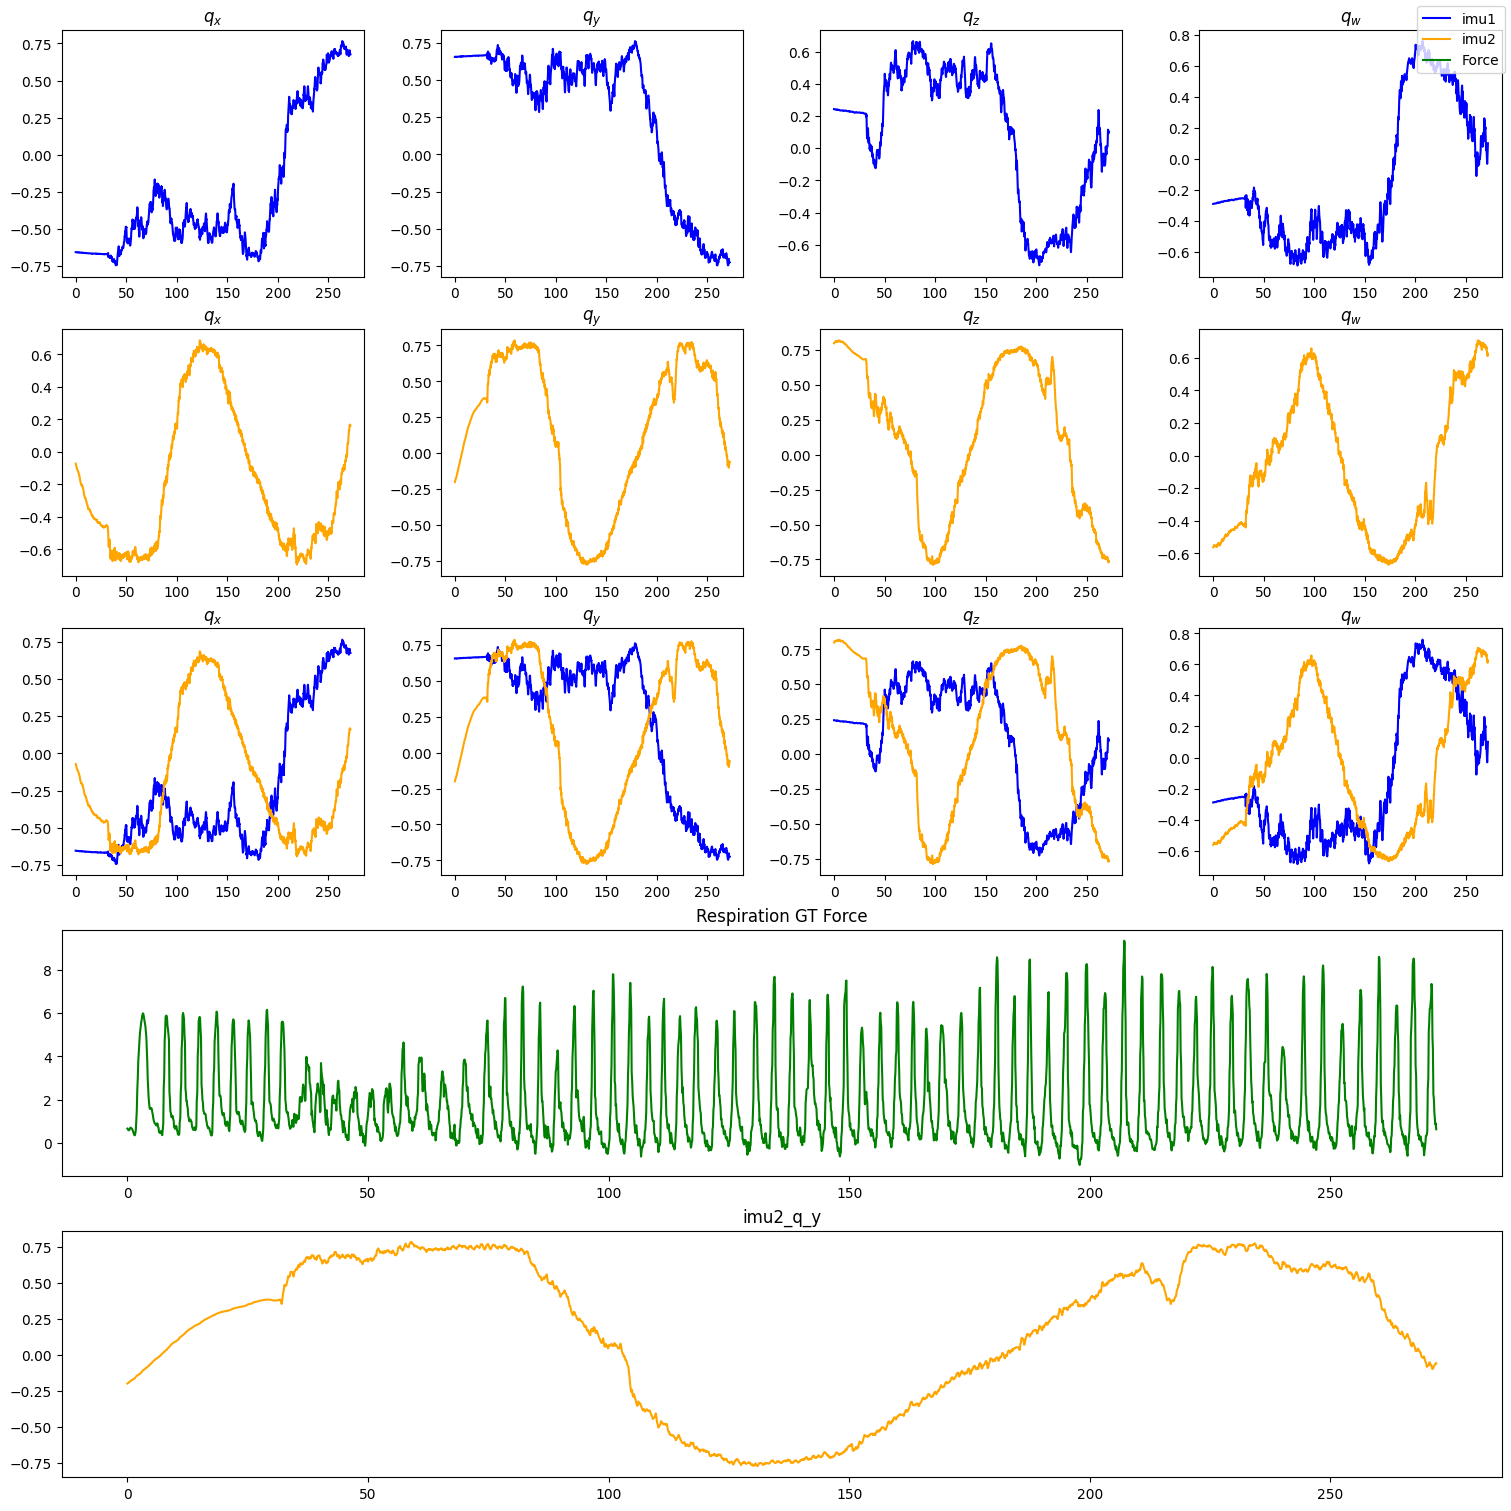

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

file_path = "./data/3_19/train/walk_stand_1.csv" 

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

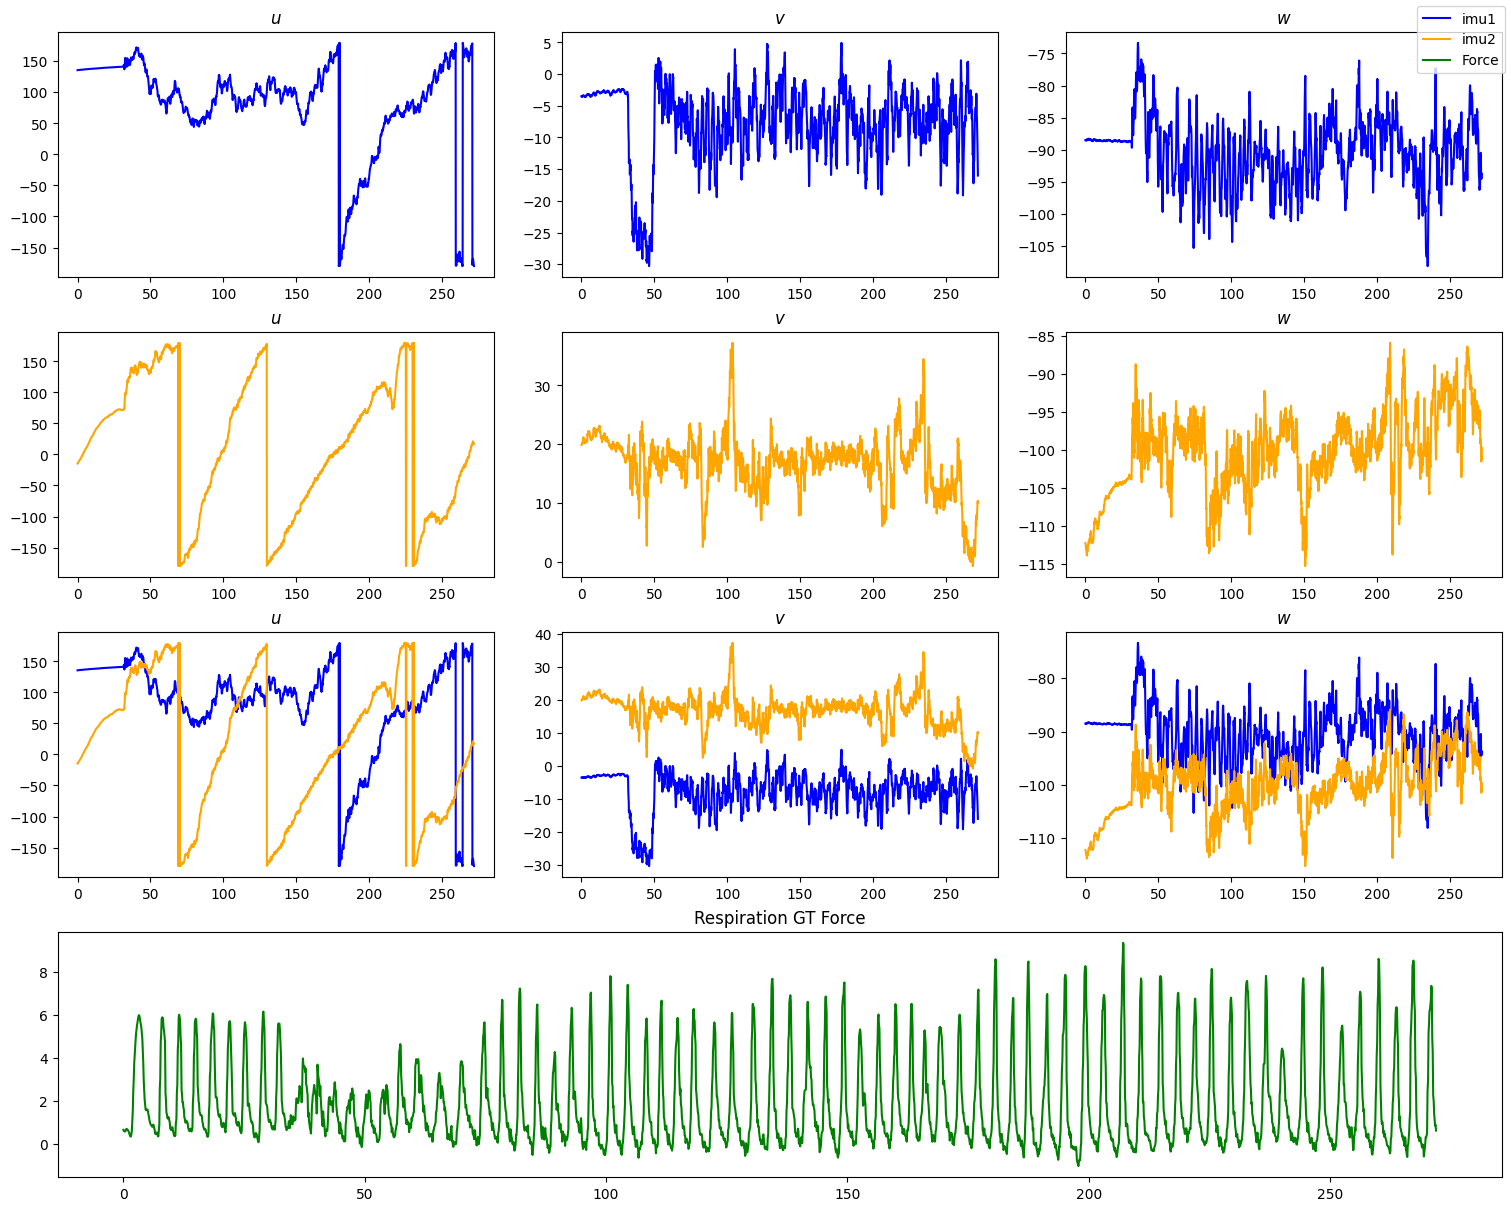

In [3]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=False)

In [4]:
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

best_score/total: 50/300


In [5]:
target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

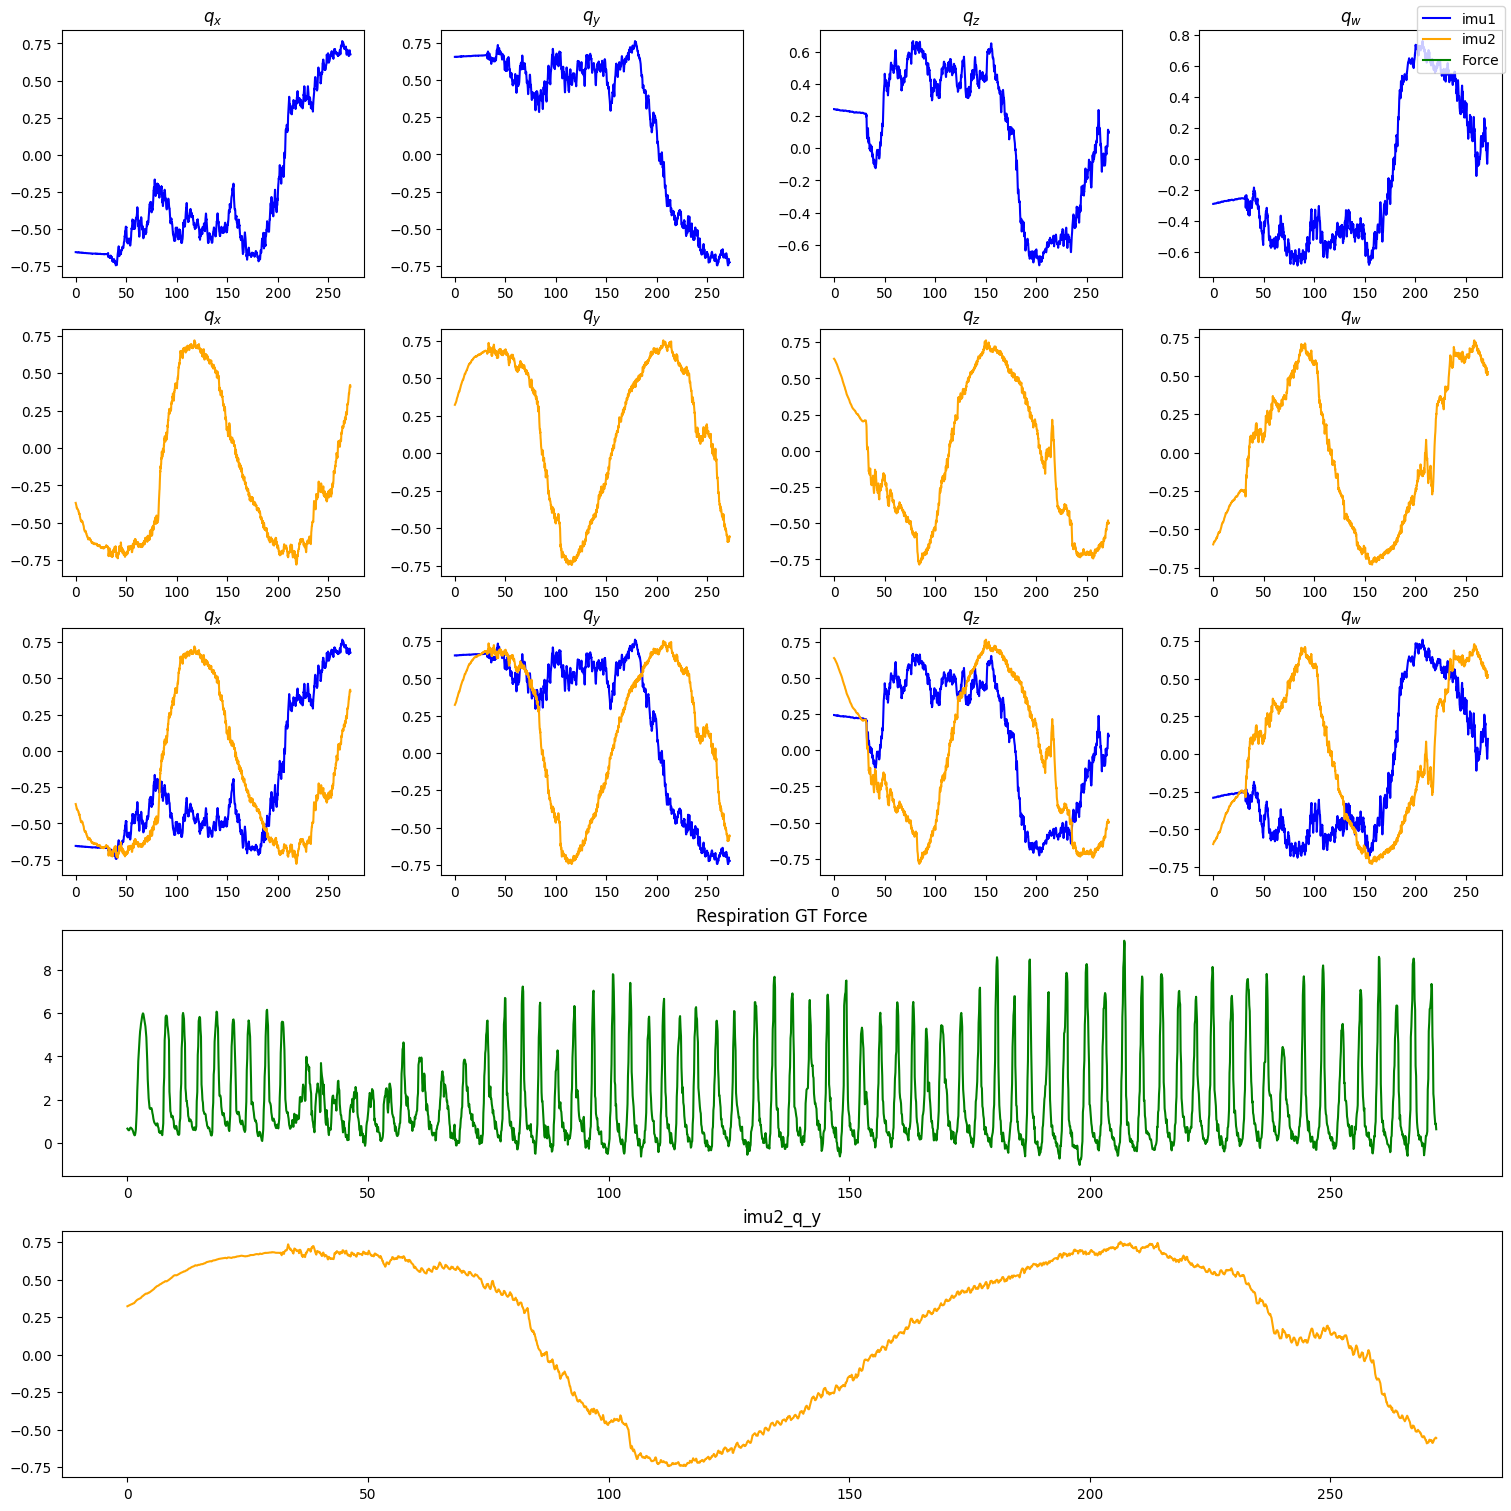

In [6]:
draw_imu_curve(data_aligned, overlap=True, show_gt=True)
# draw_imu_curve(data_aligned, overlap=True, show_gt=False)

# Spectrogram with MLP

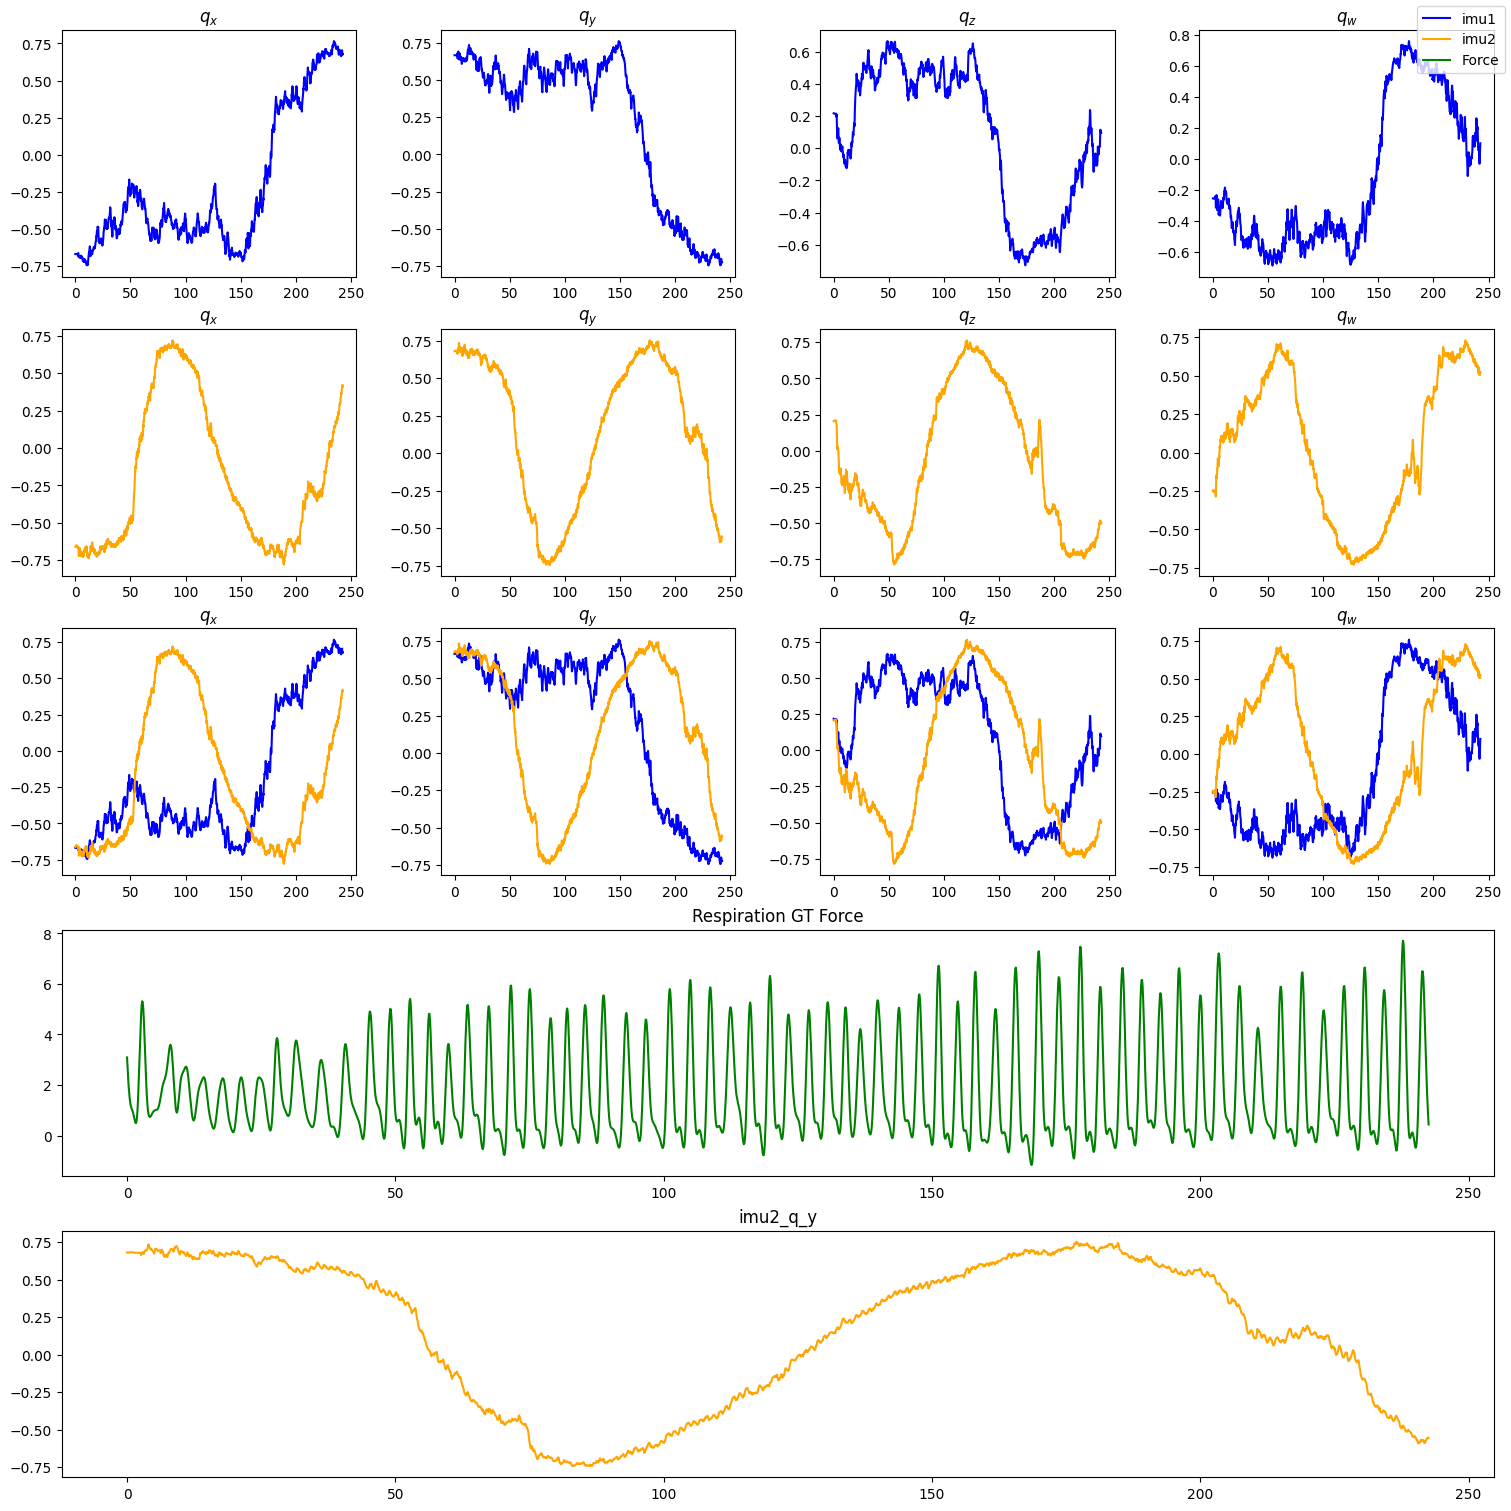

In [7]:
data_scl = data_aligned # data used in anc
data_scl = data_scl[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion
# cols = ['u', 'v', 'w'] # for euler angle
# cols = ['\omega_u', '\omega_v', '\omega_w'] # for angular velocity

data_scl.loc[:, "Force"] = butter_filter(data_scl["Force"], cutoff=0.66)
draw_imu_curve(data_scl, overlap=True, show_gt=True)

In [8]:
q_col_ls = []
for imu in sensor_names:
    for col in cols:
        q_col_ls.append(imu + "_" + col)

Q = data_scl[q_col_ls].values
Q.shape

(2486, 8)

In [9]:
# fs=10, nperseg=128, noverlap=64
def compute_spectrogram(imu_data, fs=10, nperseg=128, noverlap=64):
    """
    Convert raw IMU data into spectrograms.
    
    Args:
        imu_data: (num_samples, 8) raw IMU data
        fs: Sampling frequency of IMU data (adjust as needed)
        nperseg: Window size for STFT
        noverlap: Overlapping samples
        
    Returns:
        spectrograms: (num_samples, 8, freq_bins, time_steps)
    """
    num_samples, num_channels = imu_data.shape
    spectrograms = []

    for i in range(num_channels):  # Loop over 8 IMU channels
        f, t, Sxx = sg.spectrogram(imu_data[:, i], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spectrograms.append(Sxx)  # Shape (freq_bins, time_steps)

    spectrograms = np.stack(spectrograms, axis=0)  # (8, freq_bins, time_steps)
    
    return spectrograms

def compute_gt(force_seg, fs=10, nperseg=128, noverlap=64):
    N = len(force_seg) # Signal length in samples
    T = 1/fs # Sampling period
    n = nperseg # lag
    t = N / fs # Signal length in seconds
    flag = -10 # No freq. symbol
    # print(f'f_s :{fs}, T:{T}, N:{N}, n:{n}, t:{t}')

    window_size = n
    overlap_size = noverlap
    window_num = int((N - n) / (n - overlap_size)) + 1

    # print(f'window_num:{window_num}, overlap_size:{overlap_size}, window_size:{window_size}')

    # Initialize
    freqs, calrities, mae = {}, {}, {}
    gt, times = {}, []

    # Auto-correlation for gt, add times
    gt['freq'], gt['calrity'] = [], []
    for i in range(window_num):
        frame_start = i * (window_size - overlap_size)
        frame_segment = force_seg[frame_start:frame_start+window_size]
        
        acf = sm.tsa.acf(frame_segment, nlags=n)
        peaks = sg.find_peaks(acf)[0] # Find peaks of the autocorrelation
        if peaks.any():
            lag = peaks[0] # Choose the first peak as our pitch component lag
            pitch = fs / lag # Transform lag into frequency
            clarity = acf[lag] / acf[0]
            gt['freq'].append(pitch)
            gt['calrity'].append(clarity)
        else: # peaks is empty
            gt['freq'].append(flag)
            gt['calrity'].append(flag)
        
        times.append((frame_start + frame_start + window_size) / (2 * fs))

    return gt['freq']

# Example usage
spectrogram_data = compute_spectrogram(Q)  # Shape: (8, freq_bins, time_steps)

print(spectrogram_data.shape)

(8, 65, 37)


In [10]:
# window_size=1000, stride=500
# window_size=512, stride=256
# window_size=1024, stride=256
def segment_data(imu_data, force, window_size=128, stride=64, nperseg=128, noverlap=64, fs=10, return_t=False):
    """
    Create spectrogram windows from IMU data.

    Args:
        imu_data: (num_samples, 8) IMU data
        window_size: Number of IMU samples per spectrogram window
        stride: Step size for moving window
        
    Returns:
        segmented_spectrograms: (num_windows, 8, freq_bins, time_steps)
        segmented_gt: (num_windows, time_steps)
    """
    num_samples, num_channels = imu_data.shape
    nperseg, noverlap = 128, 64
    windows = []
    gts = []
    t = []

    for start in range(0, num_samples - window_size, stride):
        window_q = imu_data[start:start + window_size, :]
        window_force = force[start:start + window_size]
        spectrograms = compute_spectrogram(window_q, nperseg=nperseg, noverlap=noverlap)  # (8, freq_bins, time_steps)
        gt = compute_gt(window_force, nperseg=nperseg, noverlap=noverlap)
        windows.append(spectrograms)
        gts.append(gt)
        t.append((2 * start + window_size) / (2 * fs))
        
    if return_t:
        return np.stack(windows, axis=0), np.stack(gts, axis=0), np.array(t)
    else:
        return np.stack(windows, axis=0), np.stack(gts, axis=0)  # (num_windows, 8, freq_bins, time_steps), (num_windows, time_steps)

# segmented_spectrograms, segmented_gt = segment_data(Q, data_scl["Force"], window_size=128, stride=64)
segmented_spectrograms, segmented_gt = segment_data(Q, data_scl["Force"])
print(segmented_spectrograms.shape)
print(segmented_gt.shape)

(37, 8, 65, 1)
(37, 1)


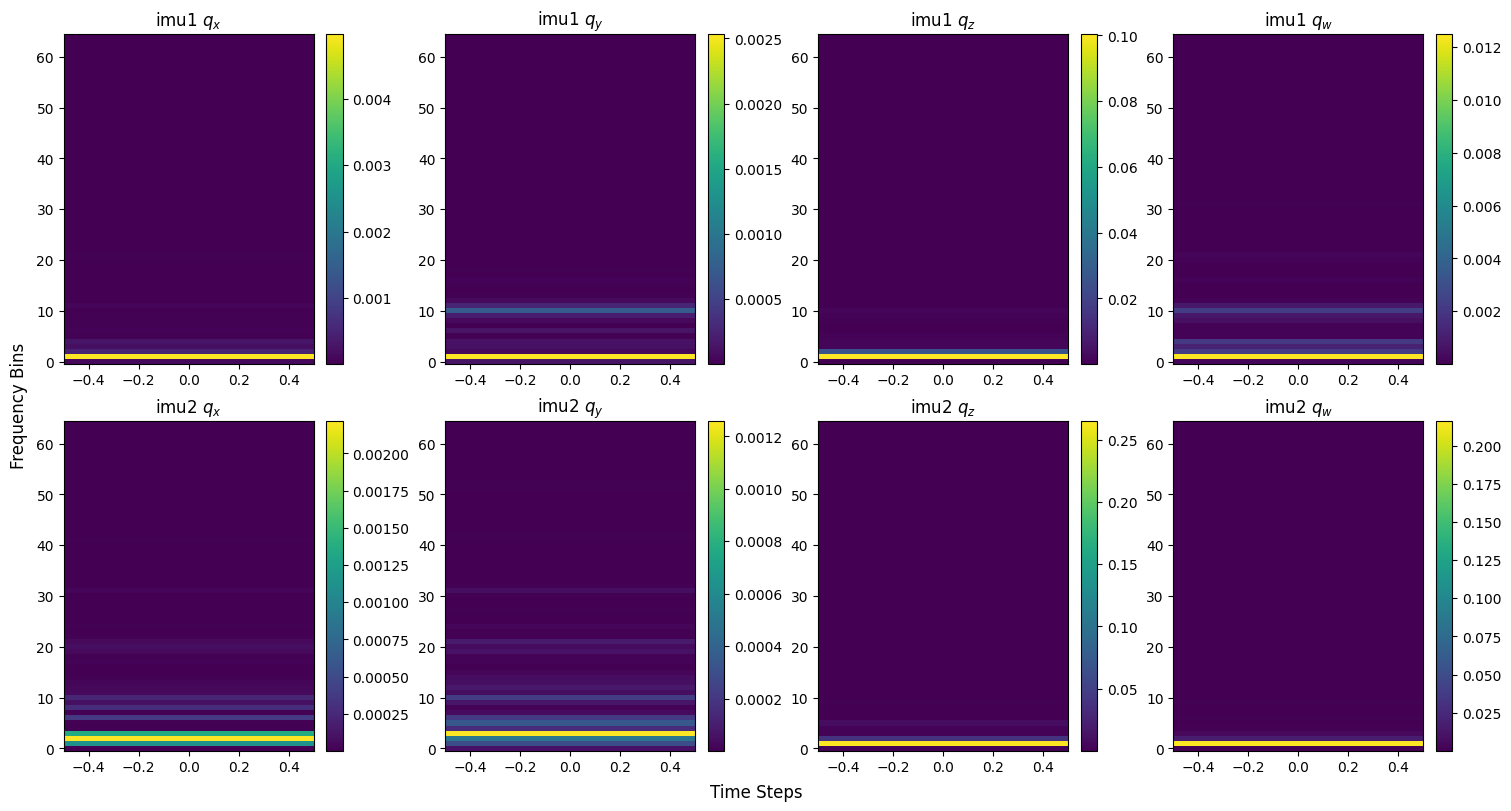

In [11]:
# spectrograms: (channel_nums, freq_bins, time_steps)
def plot_spectrogram(spectrograms, sensor_names=['imu1','imu2'], cols=['q_x', 'q_y', 'q_z', 'q_w']):
    """
    Visualizes a spectrogram.
    
    Args:
        spectrogram (numpy.ndarray or torch.Tensor): 2D array of shape (freq_bins, time_steps).
        title (str): Title of the plot.
        cmap (str): Colormap for visualization.
    """
    # if isinstance(spectrogram, torch.Tensor):
    #     spectrogram = spectrogram.cpu().numpy()  # Convert tensor to numpy

    titles = []
    for i in range(len(cols)):
        titles.append(f'${cols[i]}$')

    title = "Spectrogram"
    cmap = "viridis"

    row_num = len(sensor_names)
    fig = plt.figure(figsize=(15, (spectrograms.shape[0] // 2) * row_num), layout="constrained")
    spec = fig.add_gridspec(row_num, len(titles))
    ax_ls = []

    for k, key in enumerate(sensor_names):
        if key not in sensor_names:
            continue
        for i in range(len(titles)):
            ax = fig.add_subplot(spec[k, i % len(cols)])
            a = ax.imshow(spectrograms[k * (spectrograms.shape[0] // 2) + i % len(cols)], aspect="auto", origin="lower", cmap=cmap)
            # ax.set_xlabel("Time Steps")
            # ax.set_ylabel("Frequency Bins")
            ax.set_title(key + " " + titles[i])

            # show color bar
            plt.colorbar(a, ax=ax)
    
    fig.supxlabel('Time Steps')
    fig.supylabel('Frequency Bins')
    plt.show()

plot_spectrogram(segmented_spectrograms[0])

In [12]:
torch.cuda.is_available()

True

In [57]:
# class CNN_BiLSTM(nn.Module):
#     def __init__(self, num_freq_bins, num_time_steps, num_channels=8, hidden_dim=64):
#         super(CNN_BiLSTM, self).__init__()

#         # CNN feature extractor (per time step)
#         self.cnn = nn.Sequential(
#             nn.Conv1d(num_channels, 32, kernel_size=3, padding=1),  # Conv on freq axis
#             nn.ReLU(),
#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU()
#         )

#         # Compute CNN output shape dynamically
#         with torch.no_grad():
#             dummy_input = torch.zeros(1, num_channels, num_freq_bins)
#             cnn_out_shape = self.cnn(dummy_input).shape
#             self.cnn_feature_dim = cnn_out_shape[1]  # Extracted feature dimension

#         # BiLSTM for sequence modeling (maintains time_steps)
#         self.lstm = nn.LSTM(input_size=self.cnn_feature_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)

#         # Fully connected layer for regression
#         self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional

#     def forward(self, x):
#         batch_size, channels, freq_bins, time_steps = x.shape
#         # print(f'1: (batch_size, channels, freq_bins, time_steps) {x.shape}')

#         # Reshape to apply CNN independently per time step
#         x = x.permute(0, 3, 1, 2)  # (batch, time_steps, channels, freq_bins)
#         x = x.reshape(batch_size * time_steps, channels, freq_bins)  # Flatten batch & time for CNN

#         # Apply CNN (per time step)
#         x = self.cnn(x)  # (batch*time_steps, cnn_feature_dim, freq_bins)
#         x = torch.mean(x, dim=2)  # Global average pooling over freq_bins (batch*time_steps, cnn_feature_dim)

#         # Reshape back to (batch, time_steps, features)
#         x = x.view(batch_size, time_steps, -1)

#         # BiLSTM for sequence modeling
#         print(f'lstm input: {x.shape}')
#         x, _ = self.lstm(x)  # (batch, time_steps, hidden_dim*2)

#         # Fully connected output per time step
#         x = self.fc(x).squeeze(-1)  # (batch, time_steps)
#         # print(f'6: (batch, time_steps), {x.shape}')

#         return x
    
class SimpleNN(nn.Module):
    def __init__(self, num_freq_bins, num_time_steps, num_channels=8, hidden_dim=512): # hidden_dim=128
        super(SimpleNN, self).__init__()

        input_dim = num_channels * num_freq_bins  # Flattened input per time step

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, 1)  # Output one value per time step
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        batch_size, channels, freq_bins, time_steps = x.shape

        # Flatten channel & frequency bins at each time step
        x = x.permute(0, 3, 1, 2).reshape(batch_size, time_steps, -1)  # (batch, time_steps, features)

        # Pass through NN
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  # (batch, time_steps, 1)

        return x.squeeze(-1)  # (batch, time_steps)
    
class IMUSpectrogramDataset(Dataset):
    def __init__(self, spectrograms, respiration_rates):
        """
        Args:
            spectrograms: (num_windows, 8, freq_bins, time_steps)
            respiration_rates: (num_windows, time_steps)
        """
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32)
        self.respiration_rates = torch.tensor(respiration_rates, dtype=torch.float32)
        
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.respiration_rates[idx]

def train_model(model, train_loader, test_loader, num_epochs=20, device="cuda", visualize=False):
    model.to(device)
    
    # Loss functions
    criterion_mse = nn.MSELoss()  # Mean Squared Error (Regression Loss)
    criterion_l1 = nn.L1Loss()  # L1 Loss (Mean Absolute Error)
    mse_train_ls, l1_train_ls, mse_test_ls, l1_test_ls = [], [], [], []
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # model.train()
    for epoch in range(num_epochs):
        # train
        model.train()
        total_mse_loss_train = 0
        total_l1_loss_train = 0
        for spectrograms, respiration_rates in train_loader:
            spectrograms, respiration_rates = spectrograms.to(device), respiration_rates.to(device)

            # print(f'respiration_rates: {respiration_rates}')

            optimizer.zero_grad()
            outputs = model(spectrograms)  # Shape: (batch, time_steps)
            # print(f'outputs: {outputs}')
            
            mse_loss = criterion_mse(outputs, respiration_rates)
            l1_loss = criterion_l1(outputs, respiration_rates)

            # eta = 5
            # l1_loss = torch.clamp(l1_loss,max = eta)
           
            if not l1_loss.isnan(): # no nan values 
                 # mse_loss.backward()
                l1_loss.backward()
                optimizer.step()
            
                total_mse_loss_train += mse_loss.item()
                total_l1_loss_train += l1_loss.item()

        avg_mse_loss_train = total_mse_loss_train / len(train_loader)
        avg_l1_loss_train = 60 * total_l1_loss_train / len(train_loader) # 1/min
        mse_train_ls.append(avg_mse_loss_train)
        l1_train_ls.append(avg_l1_loss_train)

        # eval
        model.eval()
        total_mse_loss_test = 0
        total_l1_loss_test = 0

        with torch.no_grad():  # No gradient computation during evaluation
            for spectrograms, respiration_rates in test_loader:
                spectrograms, respiration_rates = spectrograms.to(device), respiration_rates.to(device)

                # Forward pass
                outputs = model(spectrograms)  # Shape: (batch, time_steps)

                # Compute losses
                mse_loss = criterion_mse(outputs, respiration_rates)
                l1_loss = criterion_l1(outputs, respiration_rates)

                if not l1_loss.isnan(): # no nan values 
                    total_mse_loss_test += mse_loss.item()
                    total_l1_loss_test += l1_loss.item()

        # Compute average loss over all batches
        avg_mse_loss_test = total_mse_loss_test / len(test_loader)
        avg_l1_loss_test = 60 * total_l1_loss_test / len(test_loader)
        mse_test_ls.append(avg_mse_loss_test)
        l1_test_ls.append(avg_l1_loss_test)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {avg_mse_loss_train:.4f}, L1: {avg_l1_loss_train:.4f}, Test MSE: {avg_mse_loss_test:.4f}, L1: {avg_l1_loss_test:.4f}")

    # draw results
    if visualize:
        draw_loss_epoch(mse_train_ls, l1_train_ls, mse_test_ls, l1_test_ls)

def draw_loss_epoch(mse_train_ls, l1_train_ls, mse_test_ls, l1_test_ls):
    colors = ['blue', 'orange']
    titles = ['MSE loss', 'L1 loss (1/min)']
    labels = ['train', 'test']
    loss_ls = [[mse_train_ls, mse_test_ls], [l1_train_ls, l1_test_ls]]

    fig = plt.figure(figsize=(10, 5), layout="constrained")
    spec = fig.add_gridspec(1, len(loss_ls))
    epoch = np.arange(1, len(mse_train_ls) + 1)

    for i in range(len(loss_ls)):
        ax = fig.add_subplot(spec[0, i])
        for j in range(len(loss_ls[i])):
            ax.plot(epoch, loss_ls[i][j], color=colors[j], label=labels[j])
        ax.set_title(titles[i])
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.show()

In [15]:
num_windows = segmented_spectrograms.shape[0]
num_freq_bins = segmented_spectrograms.shape[2]  # From computed spectrogram
num_time_steps = segmented_spectrograms.shape[3]
num_channels = 8

# Load dataset
dataset = IMUSpectrogramDataset(segmented_spectrograms, segmented_gt)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True) # batch_size=16

In [ ]:
# Initialize model
# model = CNN_BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels)
model = SimpleNN(num_freq_bins, num_time_steps, num_channels=num_channels)

# (batch_size, channels, freq_bins, time_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, train_loader, num_epochs=100, device=device)

Epoch 1/100, Train MSE: 0.0256, L1: 8.0846, Test MSE: 0.0054, L1: 3.8345
Epoch 2/100, Train MSE: 0.0042, L1: 2.5603, Test MSE: 0.0039, L1: 1.8457
Epoch 3/100, Train MSE: 0.0033, L1: 1.6307, Test MSE: 0.0029, L1: 1.6803
Epoch 4/100, Train MSE: 0.0029, L1: 1.7736, Test MSE: 0.0032, L1: 1.6676
Epoch 5/100, Train MSE: 0.0030, L1: 1.6596, Test MSE: 0.0031, L1: 1.6251
Epoch 6/100, Train MSE: 0.0031, L1: 1.6976, Test MSE: 0.0027, L1: 1.5392
Epoch 7/100, Train MSE: 0.0028, L1: 1.6367, Test MSE: 0.0030, L1: 1.6006
Epoch 8/100, Train MSE: 0.0029, L1: 1.6463, Test MSE: 0.0034, L1: 1.8580
Epoch 9/100, Train MSE: 0.0033, L1: 1.9352, Test MSE: 0.0025, L1: 1.7639
Epoch 10/100, Train MSE: 0.0058, L1: 2.5771, Test MSE: 0.0025, L1: 1.6996
Epoch 11/100, Train MSE: 0.0028, L1: 1.7428, Test MSE: 0.0033, L1: 2.0976
Epoch 12/100, Train MSE: 0.0028, L1: 1.7191, Test MSE: 0.0020, L1: 1.4335
Epoch 13/100, Train MSE: 0.0022, L1: 1.5034, Test MSE: 0.0019, L1: 1.5280
Epoch 14/100, Train MSE: 0.0020, L1: 1.4456, Te

In [17]:
# Inference
model.eval()
with torch.no_grad():
    for spectrograms, respiration_rates in train_loader:
        # print(respiration_rates)
        spectrograms = spectrograms.to(device)
        print(f'gt: {spectrograms.shape}')
        # print(spectrograms[0])
        # print(spectrograms[1])
        predictions = model(spectrograms)
        print(f'pred: {predictions.shape}')
        # print(predictions)
        print("Predicted Respiration Rates:", predictions.cpu().numpy())  # Print first sample
        print(predictions.cpu().numpy().shape)
        print(f'mae: {60 * np.mean(np.abs(predictions.cpu().numpy() - respiration_rates.cpu().numpy()))} 1/min')
        # break

gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.25179696]
 [0.23570475]
 [0.25576457]
 [0.2336004 ]]
(4, 1)
mae: 0.8531130105257034 1/min
gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.24950807]
 [0.48653767]
 [0.2535535 ]
 [0.24013887]]
(4, 1)
mae: 1.5100693702697754 1/min
gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.24581201]
 [0.23855808]
 [0.23486875]
 [0.27598912]]
(4, 1)
mae: 1.3523221760988235 1/min
gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.22819375]
 [0.23623045]
 [0.24197118]
 [0.27859044]]
(4, 1)
mae: 0.7130970060825348 1/min
gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.27102917]
 [0.2610983 ]
 [0.26231116]
 [0.2472844 ]]
(4, 1)
mae: 1.1856693774461746 1/min
gt: torch.Size([4, 8, 65, 1])
pred: torch.Size([4, 1])
Predicted Respiration Rates: [[0.2457403 ]
 [0.2511111 

In [18]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()  # Set model to evaluation mode

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()

    total_mse_loss = 0
    total_l1_loss = 0
    num_batches = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for spectrograms, respiration_rates in test_loader:
            spectrograms, respiration_rates = spectrograms.to(device), respiration_rates.to(device)

            # Forward pass
            outputs = model(spectrograms)  # Shape: (batch, time_steps)

            # Compute losses
            mse_loss = criterion_mse(outputs, respiration_rates)
            l1_loss = criterion_l1(outputs, respiration_rates)

            total_mse_loss += mse_loss.item()
            total_l1_loss += l1_loss.item()
            num_batches += 1

    # Compute average loss over all batches
    avg_mse_loss = total_mse_loss / num_batches
    avg_l1_loss = 60 * total_l1_loss / num_batches

    print(f"Evaluation Results - MSE Loss: {avg_mse_loss:.4f}, L1 Loss: {avg_l1_loss:.4f} 1/min")
    return avg_mse_loss, avg_l1_loss

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# evaluate_model(model, test_loader, device=device)
mse, mae = evaluate_model(model, train_loader, device=device)

Evaluation Results - MSE Loss: 0.0004, L1 Loss: 1.0770 1/min


In [19]:
def prepare_data(dir, fs=10, start_pt=0, end_pt=-1, still_pt=300, after_still_pt=0, pool=1.0, d=0.1):
    sensor_names=['imu1','imu2']
    cols = ['q_x', 'q_y', 'q_z', 'q_w']
    q_col_ls = []
    for imu in sensor_names:
        for col in cols:
            q_col_ls.append(imu + "_" + col)

    spectrograms, gts = [], []
    # iterate all files
    for file in os.listdir(dir):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            print(os.path.join(dir, filename))
            
            # load data
            data = pd.read_csv(os.path.join(dir, filename))
            data.columns = [
                "Timestamp",
                "imu1_q_x",
                "imu1_q_y",
                "imu1_q_z",
                "imu1_q_w",
                "imu2_q_x",
                "imu2_q_y",
                "imu2_q_z",
                "imu2_q_w",
                "Force",
                "RR",
            ]

            data = data.iloc[start_pt:end_pt]

            data = align_delay(data, delay=10)
            data["Timestamp"] = pd.to_datetime(data["Timestamp"])
            data = data.set_index("Timestamp")

            # align IMU
            q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)
            target, skew = 'imu1', 'imu2'
            Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
            Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
            data_aligned = data.copy()

            for i, col in enumerate(cols):
                data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

            # specify data range
            data_sml = data_aligned # data used in sml
            data_sml = data_sml[still_pt+after_still_pt:]
            cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

            data_sml.loc[:, "Force"] = butter_filter(data_sml["Force"], cutoff=0.66)

            # Q: (sample_num, channel_num)
            Q = data_sml[q_col_ls].values
            segmented_spectrograms, segmented_gt = segment_data(Q, data_sml["Force"])
            # print(f'sepctrograms:{segmented_spectrograms.shape}')
            # print(f'gt:{segmented_gt.shape}')
            spectrograms.append(segmented_spectrograms)
            gts.append(segmented_gt)
    
    spectrograms = np.concatenate(spectrograms, axis=0)
    gts = np.concatenate(gts, axis=0)

    print('----------------------------')
    print(f'sepctrograms:{spectrograms.shape}')
    print(f'gt:{gts.shape}')

    return spectrograms, gts

path_train = './data/3_19/train/'
path_test = './data/3_19/test/'
spectrograms_train, gts_train = prepare_data(path_train)
spectrograms_test, gts_test = prepare_data(path_test)

./data/3_19/train/run_stand_1.csv
best_score/total: 51/300
./data/3_19/train/run_stand_2.csv
best_score/total: 140/300
./data/3_19/train/sit_1.csv
best_score/total: 300/300
./data/3_19/train/sit_2.csv
best_score/total: 231/300
./data/3_19/train/stand_1.csv
best_score/total: 300/300
./data/3_19/train/stand_2.csv
best_score/total: 300/300
./data/3_19/train/walk_stand_1.csv
best_score/total: 50/300
./data/3_19/train/walk_stand_2.csv
best_score/total: 300/300
----------------------------
sepctrograms:(289, 8, 65, 1)
gt:(289, 1)
./data/3_19/test/run_stand_3.csv
best_score/total: 259/300
./data/3_19/test/sit_3.csv
best_score/total: 300/300
./data/3_19/test/stand_3.csv
best_score/total: 298/300
./data/3_19/test/walk_stand_3.csv
best_score/total: 237/300
----------------------------
sepctrograms:(145, 8, 65, 1)
gt:(145, 1)


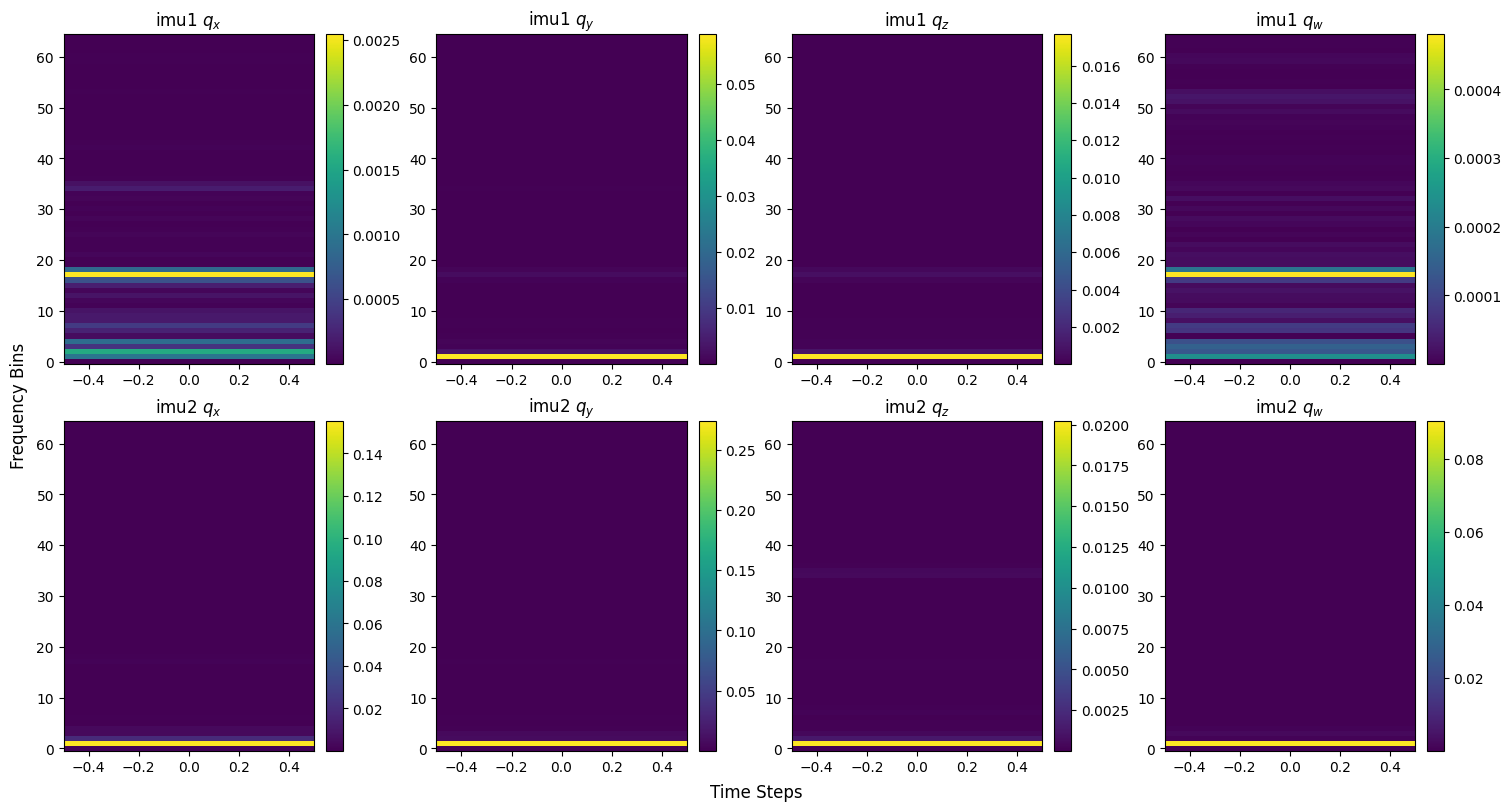

In [20]:
plot_spectrogram(spectrograms_train[0])

Epoch 1/100, Train MSE: 0.0040, L1: 2.4841, Test MSE: 0.0031, L1: 2.4104
Epoch 2/100, Train MSE: 0.0016, L1: 1.5459, Test MSE: 0.0018, L1: 1.6997
Epoch 3/100, Train MSE: 0.0016, L1: 1.4581, Test MSE: 0.0019, L1: 1.6578
Epoch 4/100, Train MSE: 0.0013, L1: 1.3871, Test MSE: 0.0022, L1: 2.0035
Epoch 5/100, Train MSE: 0.0012, L1: 1.2632, Test MSE: 0.0017, L1: 1.4761
Epoch 6/100, Train MSE: 0.0010, L1: 1.1652, Test MSE: 0.0018, L1: 1.4637
Epoch 7/100, Train MSE: 0.0014, L1: 1.1824, Test MSE: 0.0019, L1: 1.7683
Epoch 8/100, Train MSE: 0.0011, L1: 1.1273, Test MSE: 0.0016, L1: 1.4152
Epoch 9/100, Train MSE: 0.0011, L1: 1.0635, Test MSE: 0.0016, L1: 1.4265
Epoch 10/100, Train MSE: 0.0010, L1: 1.0340, Test MSE: 0.0018, L1: 1.4567
Epoch 11/100, Train MSE: 0.0018, L1: 1.2383, Test MSE: 0.0016, L1: 1.4719
Epoch 12/100, Train MSE: 0.0011, L1: 1.0883, Test MSE: 0.0018, L1: 1.5938
Epoch 13/100, Train MSE: 0.0008, L1: 0.9886, Test MSE: 0.0016, L1: 1.5164
Epoch 14/100, Train MSE: 0.0010, L1: 1.0457, Te

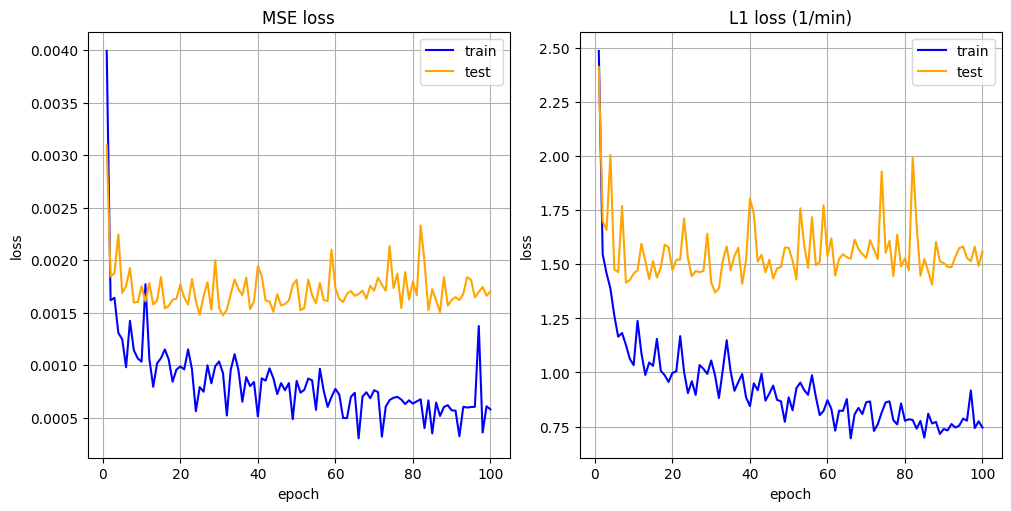

In [63]:
num_freq_bins = spectrograms_train.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_train.shape[3]
num_channels = 8

# Load dataset
# spectrograms_train = np.log(spectrograms_train) # log info
dataset_train = IMUSpectrogramDataset(spectrograms_train, gts_train)
dataset_test = IMUSpectrogramDataset(spectrograms_test, gts_test)
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True) # batch_size=16
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True)

model = SimpleNN(num_freq_bins, num_time_steps, num_channels=num_channels)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, test_loader, num_epochs=100, device=device, visualize=True)

In [64]:
# Evaluate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mse, mae = evaluate_model(model, test_loader, device=device)

Evaluation Results - MSE Loss: 0.0018, L1 Loss: 1.6260 1/min


In [88]:
def prepare_file(file, fs=10, start_pt=0, end_pt=-1, still_pt=300, after_still_pt=0, pool=1.0, d=0.1):
    sensor_names=['imu1','imu2']
    cols = ['q_x', 'q_y', 'q_z', 'q_w']
    q_col_ls = []
    for imu in sensor_names:
        for col in cols:
            q_col_ls.append(imu + "_" + col)

    spectrograms, gts, times = [], [], []

    # load data
    data = pd.read_csv(file)
    data.columns = [
        "Timestamp",
        "imu1_q_x",
        "imu1_q_y",
        "imu1_q_z",
        "imu1_q_w",
        "imu2_q_x",
        "imu2_q_y",
        "imu2_q_z",
        "imu2_q_w",
        "Force",
        "RR",
    ]

    data = data.iloc[start_pt:end_pt]

    data = align_delay(data, delay=10)
    data["Timestamp"] = pd.to_datetime(data["Timestamp"])
    data = data.set_index("Timestamp")

    # align IMU
    q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)
    target, skew = 'imu1', 'imu2'
    Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
    Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
    data_aligned = data.copy()

    for i, col in enumerate(cols):
        data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

    # specify data range
    data_sml = data_aligned # data used in sml
    data_sml = data_sml[still_pt+after_still_pt:]
    cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

    data_sml.loc[:, "Force"] = butter_filter(data_sml["Force"], cutoff=0.66)

    # Q: (sample_num, channel_num)
    Q = data_sml[q_col_ls].values
    segmented_spectrograms, segmented_gt, times = segment_data(Q, data_sml["Force"], return_t=True)
    # print(f'sepctrograms:{segmented_spectrograms.shape}')
    # print(f'gt:{segmented_gt.shape}')
    spectrograms.append(segmented_spectrograms)
    gts.append(segmented_gt)
    
    spectrograms = np.concatenate(spectrograms, axis=0)
    gts = np.concatenate(gts, axis=0)

    print('----------------------------')
    print(f'sepctrograms:{spectrograms.shape}')
    print(f'gt:{gts.shape}')
    print(f'times:{times.shape}')

    return spectrograms, gts, times


action_name = "walk_stand_3"
# sit_3,  stand_3, walk_stand_3, run_stand_3
path_file = f'./data/3_19/test/{action_name}.csv'

spectrograms_file, gts_file, times_file = prepare_file(path_file)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 237/300
----------------------------
sepctrograms:(37, 8, 65, 1)
gt:(37, 1)
times:(37,)


In [89]:
def evaluate_model_file(model, file_loader, device="cuda", gt=None, times=None, visualize=True, action_name=None):
    model.to(device)
    model.eval()  # Set model to evaluation mode

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()

    total_mse_loss = 0
    total_l1_loss = 0
    num_batches = 0

    pred = []

    with torch.no_grad():  # No gradient computation during evaluation
        for spectrograms, respiration_rates in file_loader:
            spectrograms, respiration_rates = spectrograms.to(device), respiration_rates.to(device)

            # Forward pass
            outputs = model(spectrograms)  # Shape: (batch, time_steps)
            pred.append(60 * outputs.cpu().numpy()[0][0])

            # Compute losses
            mse_loss = criterion_mse(outputs, respiration_rates)
            l1_loss = criterion_l1(outputs, respiration_rates)

            total_mse_loss += mse_loss.item()
            total_l1_loss += l1_loss.item()
            num_batches += 1

    # Compute average loss over all batches
    avg_mse_loss = total_mse_loss / num_batches
    avg_l1_loss = 60 * total_l1_loss / num_batches

    preds = {"Spectrogram + MLP": np.array(pred)}

    if visualize:
        draw_learning_results(preds, 60 * gt, times, action_name)

    print(f"Evaluation Results - MSE Loss: {avg_mse_loss:.4f}, L1 Loss: {avg_l1_loss:.4f} 1/min")
    return avg_mse_loss, avg_l1_loss, preds

def draw_learning_results(preds, gt, times, action_name, cols=['q_x', 'q_y', 'q_z', 'q_w']):
    markers = ["^", "s", "P", "*"]

    fig = plt.figure(figsize=(15, 5), layout="constrained")
    gt_ok_idx = np.where(gt > 0)[0]

    plt.plot(times[gt_ok_idx], gt[gt_ok_idx], marker="o", label='gt',)

    for i, method in enumerate(preds):
        pred_ok_idx = np.where(preds[method] > 0)[0]
        all_ok_idx = list(set(gt_ok_idx) & set(pred_ok_idx))
        
        plt.plot(times[all_ok_idx], preds[method][all_ok_idx], marker=markers[i], label=method)
    
    plt.title(f"Prediction Results: {action_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("RR (1/min)")
    plt.gca().set_ylim(bottom=0)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

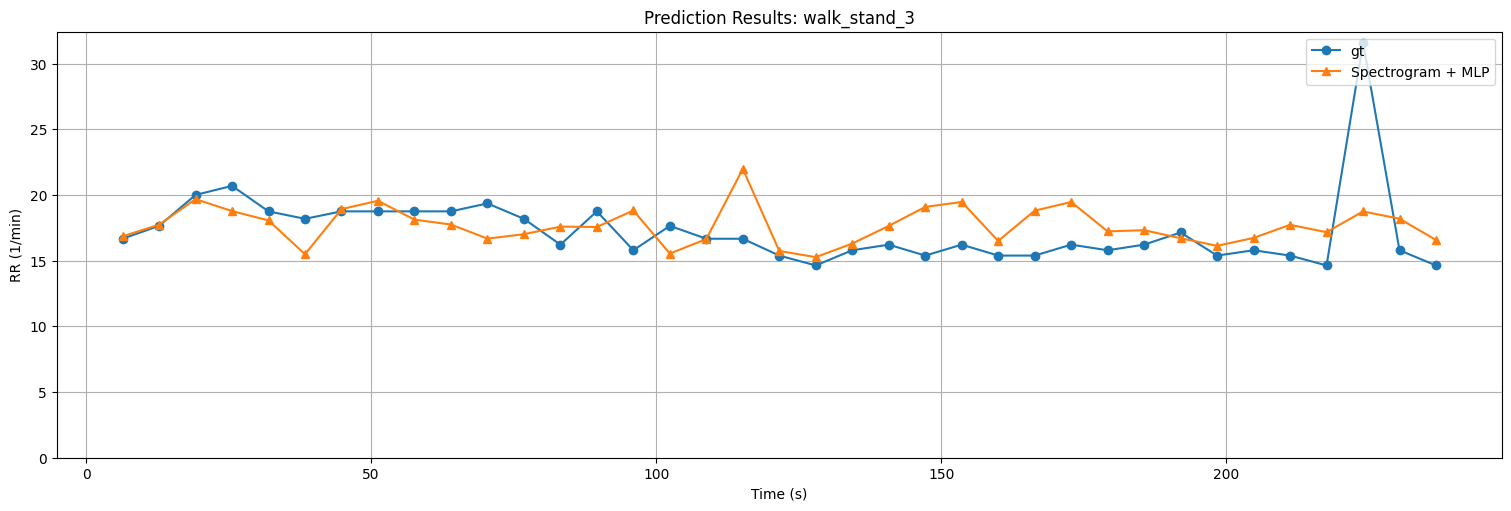

Evaluation Results - MSE Loss: 0.0023, L1 Loss: 1.8850 1/min


In [90]:
avg_mse_loss, avg_l1_loss, preds = evaluate_model_file(model, file_loader, gt=np.reshape(gts_file, (-1)), times=times_file, action_name=action_name)